In [1]:
!nvidia-smi

Sat Apr  6 16:22:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn  # 신경망 모듈, 구축 및 훈련에 사용
from torch.utils.data.dataset import Dataset # 사용자 정의 데이터 셋을 만들어 딥러닝을 할 수 있게 함
import torchvision
import torchvision.transforms as transforms # 이미지 전처리에 필요한 transform 사용
from torch.utils.data import DataLoader # 데이터 관리에 필요한 dataloader
import torch.nn.functional as F # loss or cost gradient와 같은 여러 함수를 사용할 수 있음
from sklearn.metrics import f1_score, confusion_matrix # f1 score와 행렬을 계산 -> 모델의 성능 평가
import numpy as np # numpy 사용
import matplotlib.pyplot as plt #시각화를 위한 차트 사용
from torch.cuda import is_available
from torchvision.datasets import CIFAR10

In [3]:
device='cuda' if is_available() else 'cpu'
lr = 1e-4
batch_size=32
epoch = 10

In [4]:
all_data=CIFAR10(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)
mean = [meanR, meanG, meanB]
std = [stdR, stdG, stdB]

100%|██████████| 170498071/170498071 [00:01<00:00, 90103498.36it/s]


Extracting ./cifar-10-python.tar.gz to .
Mean: 0.49139965 0.48215845 0.4465309
Std: 0.20220213 0.19931543 0.20086348


In [19]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                        # 텐서로 변환
    transforms.Normalize(mean, std)])

In [20]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 96, kernel_size=11, stride=4), # conv1
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # conv2
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # conv3
            torch.nn.ReLU(inplace=True)
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1), # conv4
            torch.nn.ReLU(inplace=True)
        )

        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), # conv5
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(6*6*256, 4096), # fc1
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096), # fc2
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, num_classes) # fc3
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
model = Net(in_channels = 3, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr)
criterion = nn.CrossEntropyLoss()

In [23]:
from tqdm import tqdm

def train(model, train_loader, optimizer, Epoch):
    model.train()
    losses = []
    correct = 0
    total_samples = len(train_loader.dataset)

    with tqdm(total=len(train_loader), unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {Epoch+1}")
        for batch_idx, (image, label) in enumerate(train_loader):
            image = image.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            tepoch.set_postfix(loss=f"{loss.item():.4f}")
            tepoch.update(1)

    train_loss = np.mean(losses)
    accuracy = 100. * correct / total_samples

    return train_loss, accuracy


In [24]:
def evaluate(model, test_loader):
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            loss = criterion(output, label)
            losses.append(loss.item())

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss = np.mean(losses)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [26]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for Epoch in range(10):
    train_loss, train_accuracy = train(model, trainloader, optimizer, Epoch)
    test_loss, test_accuracy = evaluate(model, testloader)

    # 각 에폭별로 훈련 손실과 정확도, 테스트 손실과 정확도를 저장
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"\n[EPOCH: {Epoch+1}]\tTrain Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy} %")
    print(f"[EPOCH: {Epoch+1}]\tTest Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy} % \n")

Epoch 1: 100%|██████████| 1563/1563 [05:32<00:00,  4.70batch/s, loss=1.2690]



[EPOCH: 1]	Train Loss: 1.5135	Train Accuracy: 44.94 %
[EPOCH: 1]	Test Loss: 1.0876	Test Accuracy: 61.91 % 



Epoch 2: 100%|██████████| 1563/1563 [05:32<00:00,  4.69batch/s, loss=0.6416]



[EPOCH: 2]	Train Loss: 0.9857	Train Accuracy: 65.396 %
[EPOCH: 2]	Test Loss: 0.8920	Test Accuracy: 69.4 % 



Epoch 3: 100%|██████████| 1563/1563 [05:32<00:00,  4.70batch/s, loss=0.9286]



[EPOCH: 3]	Train Loss: 0.7822	Train Accuracy: 72.788 %
[EPOCH: 3]	Test Loss: 0.7320	Test Accuracy: 75.28 % 



Epoch 4: 100%|██████████| 1563/1563 [05:29<00:00,  4.75batch/s, loss=0.8283]



[EPOCH: 4]	Train Loss: 0.6553	Train Accuracy: 77.286 %
[EPOCH: 4]	Test Loss: 0.6383	Test Accuracy: 78.7 % 



Epoch 5: 100%|██████████| 1563/1563 [05:29<00:00,  4.74batch/s, loss=0.7601]



[EPOCH: 5]	Train Loss: 0.5705	Train Accuracy: 80.374 %
[EPOCH: 5]	Test Loss: 0.6124	Test Accuracy: 79.4 % 



Epoch 6: 100%|██████████| 1563/1563 [05:28<00:00,  4.76batch/s, loss=1.1010]



[EPOCH: 6]	Train Loss: 0.5003	Train Accuracy: 82.976 %
[EPOCH: 6]	Test Loss: 0.5953	Test Accuracy: 80.55 % 



Epoch 7: 100%|██████████| 1563/1563 [05:31<00:00,  4.72batch/s, loss=0.1784]



[EPOCH: 7]	Train Loss: 0.4313	Train Accuracy: 85.17 %
[EPOCH: 7]	Test Loss: 0.5530	Test Accuracy: 81.64 % 



Epoch 8: 100%|██████████| 1563/1563 [05:31<00:00,  4.71batch/s, loss=0.2653]



[EPOCH: 8]	Train Loss: 0.3821	Train Accuracy: 87.152 %
[EPOCH: 8]	Test Loss: 0.5473	Test Accuracy: 81.76 % 



Epoch 9: 100%|██████████| 1563/1563 [05:35<00:00,  4.66batch/s, loss=0.6340]



[EPOCH: 9]	Train Loss: 0.3361	Train Accuracy: 88.542 %
[EPOCH: 9]	Test Loss: 0.5630	Test Accuracy: 82.27 % 



Epoch 10: 100%|██████████| 1563/1563 [05:32<00:00,  4.70batch/s, loss=0.3102]



[EPOCH: 10]	Train Loss: 0.2935	Train Accuracy: 90.03 %
[EPOCH: 10]	Test Loss: 0.6191	Test Accuracy: 81.07 % 



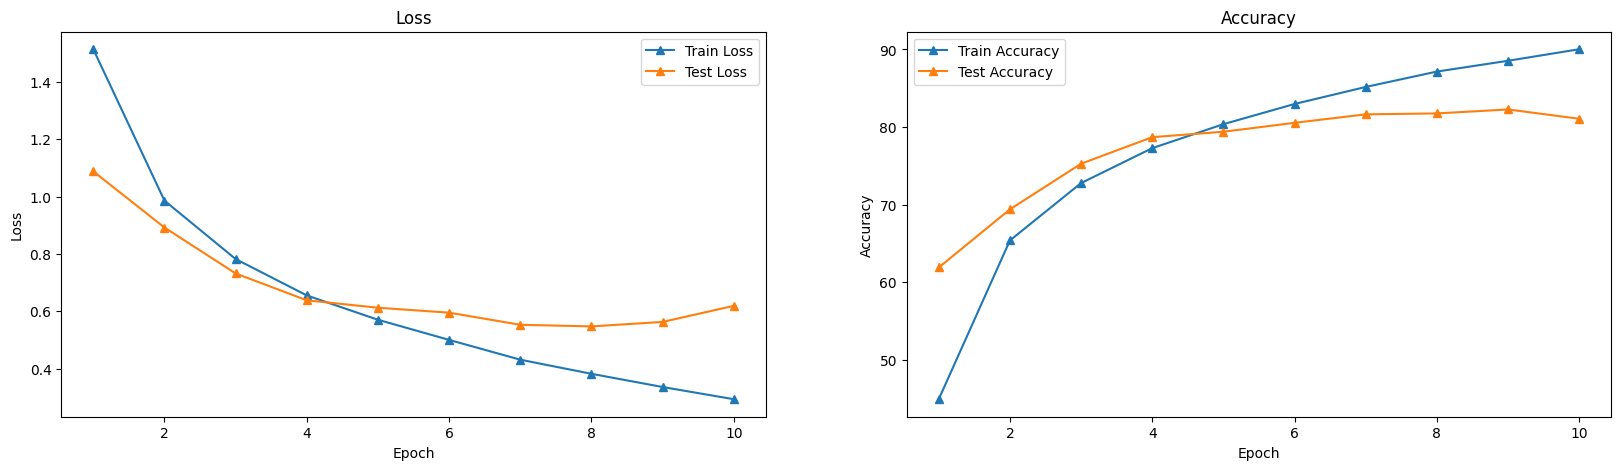

In [28]:
plt.figure(figsize=(20, 5))
epochs = range(1, 11)
# 첫 번째 그래프
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
plt.plot(epochs, train_losses, label='Train Loss',marker='^')
plt.plot(epochs, test_losses, label='Test Loss',marker='^')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 두 번째 그래프
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
plt.plot(epochs, train_accuracies, label='Train Accuracy',marker='^')
plt.plot(epochs, test_accuracies, label='Test Accuracy',marker='^')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()